In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import nibabel as nib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '..')
from utilities import CONTRASTS, GROUP_CONTRAST_IDS, plot_corr_matrices_across_contrasts, compute_corr_coeff


In [2]:
base_data_dir = '/nfs03/data/HCP_200113/derived/preprocessed'

In [3]:
mask = np.load('../data/glasser_medial_wall_mask.npy')
print(mask.shape)

(2, 32492)


In [4]:
test_subj_ids = np.genfromtxt("../data/MICCAI2020/HCP_test_restest_subj_ids.csv", dtype='<U13')

test_contrasts = []
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    contrast_file = os.path.join(base_data_dir, "contrasts", "%s_joint_LR_all_tasks.npy" % subj)
    contrast_data = np.load(contrast_file)
    test_contrasts.append(contrast_data)

test_contrasts = np.asarray(test_contrasts)
print(test_contrasts.shape)


(39, 94, 32492)


# Retest

In [5]:
retest_contrasts = []

for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    retest_contrast_file = os.path.join(base_data_dir, "HCP_Retest", "contrasts", "%s_joint_LR_all_tasks.npy" % subj)
    retest_contrast_data = np.load(retest_contrast_file)
    retest_contrasts.append(retest_contrast_data)

retest_contrasts = np.asarray(retest_contrasts)
print(retest_contrasts.shape)

(39, 94, 32492)


In [6]:
def compute_subj_contrast_corr(pred, ref, contrasts, contrast_ids, mask):
    all_lh_corr = []
    all_rh_corr = []
    all_avg_corr = []
    
    masked_lh_pred = pred[:, ::2, mask[0, :]]
    masked_rh_pred = pred[:, 1::2, mask[1, :]]
    
    masked_lh_ref = ref[:, ::2, mask[0, :]]
    masked_rh_ref = ref[:, 1::2, mask[1, :]]

    for i in range(len(contrasts)):
        lh_contrast_ref = masked_lh_ref[:, i, :]
        rh_contrast_ref = masked_rh_ref[:, i, :]
# 
        lh_contrast_pred = masked_lh_pred[:, i, :]
        rh_contrast_pred = masked_rh_pred[:, i, :]
        
#         print(lh_contrast_ref.shape)
#         print(lh_contrast_pred.shape)
#         print(lh_contrast_pred[0, :] - lh_contrast_pred[1, :])
#         print(lh_contrast_ref[0, :] - lh_contrast_ref[1, :])

        lh_corr = compute_corr_coeff(lh_contrast_ref, lh_contrast_pred)
        rh_corr = compute_corr_coeff(rh_contrast_ref, rh_contrast_pred)
        # print(lh_corr[0, :] - lh_corr[1, :])

        all_lh_corr.append(lh_corr)
        all_rh_corr.append(rh_corr)
        all_avg_corr.append((lh_corr + rh_corr) / 2)
    return all_lh_corr, all_rh_corr, all_avg_corr


In [ ]:
lh_test_retest_corr, rh_test_retest_corr, test_retest_corr = compute_subj_contrast_corr(retest_contrasts, test_contrasts, CONTRASTS, GROUP_CONTRAST_IDS, mask)

plot_corr_matrices_across_contrasts(test_retest_corr, CONTRASTS[4:7], vmax=0.8)


# BrainSurfCNN (trained with MSE)

In [8]:
base_brainsurfcnn_mse_dir = "/nfs03/users/ghn8/TaskContrastsFromRest/debug/ch50_feat64_s8_c50_lr0.01_seed28/predict/best_corr"

multisample_brainsurfcnn_mse_pred = []
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    pred_file = os.path.join(base_brainsurfcnn_mse_dir, "%s_pred.npy" % subj)
    pred = np.load(pred_file)
    multisample_brainsurfcnn_mse_pred.append(pred)

multisample_brainsurfcnn_mse_pred = np.asarray(multisample_brainsurfcnn_mse_pred)
brainsurfcnn_mse_pred = np.mean(multisample_brainsurfcnn_mse_pred, 1)
print(brainsurfcnn_mse_pred.shape)


(39, 94, 32492)


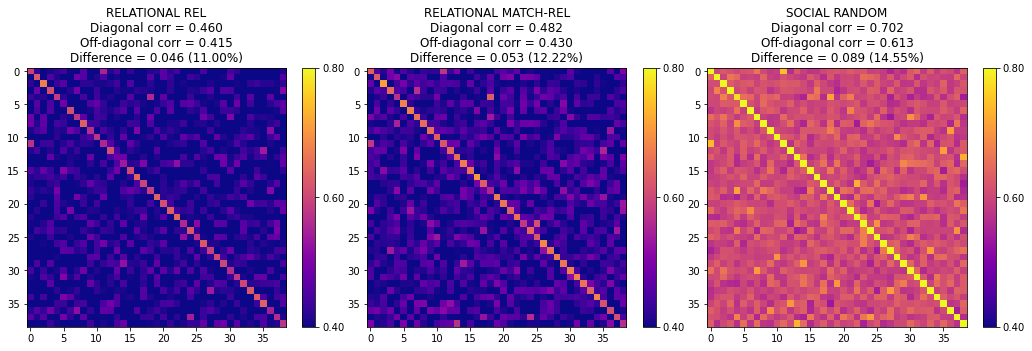

In [17]:
lh_test_brainsurfcnn_mse_corr, rh_test_brainsurfcnn_mse_corr, test_brainsurfcnn_mse_corr = compute_subj_contrast_corr(retest_contrasts, brainsurfcnn_mse_pred, CONTRASTS, GROUP_CONTRAST_IDS, mask)

plot_corr_matrices_across_contrasts(test_brainsurfcnn_mse_corr, CONTRASTS[4:7], vmin=0.4, vmax=0.8)


# BrainSurfCNN (trained with RC Loss)

In [15]:
base_brainsurfcnn_rc_dir = "/nfs03/users/ghn8/TaskContrastsFromRest/debug/ch50_scheduled_feat64_s8_c50_lr0.01_seed28/finetuned_feat64_s8_c50_lr0.01_seed28/predict_on_test_subj/best_corr/"

multisample_brainsurfcnn_rc_pred = []
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    pred_file = os.path.join(base_brainsurfcnn_rc_dir, "%s_pred.npy" % subj)
    pred = np.load(pred_file)
    multisample_brainsurfcnn_rc_pred.append(pred)

multisample_brainsurfcnn_rc_pred = np.asarray(multisample_brainsurfcnn_rc_pred)
brainsurfcnn_rc_pred = np.mean(multisample_brainsurfcnn_rc_pred, 1)
print(brainsurfcnn_rc_pred.shape)


(39, 94, 32492)


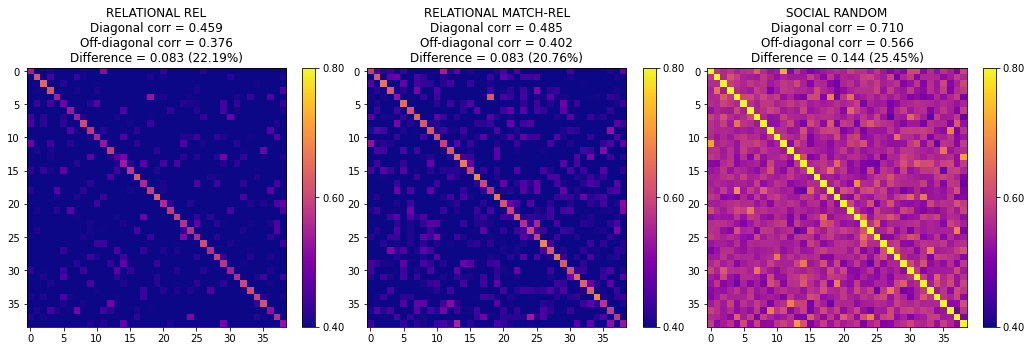

In [18]:
lh_test_brainsurfcnn_rc_corr, rh_test_brainsurfcnn_rc_corr, test_brainsurfcnn_rc_corr = compute_subj_contrast_corr(retest_contrasts, brainsurfcnn_rc_pred, CONTRASTS, GROUP_CONTRAST_IDS, mask)

plot_corr_matrices_across_contrasts(test_brainsurfcnn_rc_corr, CONTRASTS[4:7], vmin=0.4, vmax=0.8)


# Model Comparison

In [19]:
pred_by_model = {
    "Retest": test_retest_corr,
    "BrainSurfCNN - only MSE": test_brainsurfcnn_mse_corr,
    "BrainSurfCNN - RC": test_brainsurfcnn_rc_corr
}

In [20]:
# colors = [ '#fdc575', '#f99154', '#63bfa6', '#358cbb']
colors = [ '#f99154', '#63bfa6', '#358cbb']
sns.set_palette(sns.color_palette(colors))

In [21]:
df = pd.DataFrame(columns=["Model", "Task Contrast", "Subject", "Correlation with Groundtruth", "Correlation Increase of Self vs Mean Others", "Rank"])
for model in pred_by_model:
    all_subj_contrast_corr = pred_by_model[model]
    for i in range(len(CONTRASTS)):
        item = CONTRASTS[i]
        task, cope_id, contrast_label = item
        key = "%s %s" % (task, contrast_label)

        contrast_corr = all_subj_contrast_corr[i]

        count = 0
        for j in range(len(test_subj_ids)):
            count = count  + 1
            corr_row = contrast_corr[j, :]
            self_corr = corr_row[j]
            other_corrs = np.concatenate((corr_row[:j], corr_row[j+1:]))
            mean_other_corr = np.mean(other_corrs)

            num_other_gt_self = np.sum(other_corrs > self_corr)
            sorted_indices = np.flip(np.argsort(corr_row))
            for k in range(len(sorted_indices)):
                if sorted_indices[k] == j:
                    rank = k
            rank = rank + 1
            df = df.append({
                "Model": model,
                "Task Contrast": key,
                "Subject": test_subj_ids[j],
                "Correlation with Groundtruth": self_corr,
                "Correlation Increase of Self vs Mean Others": (self_corr - mean_other_corr),
                "Rank": rank
            }, ignore_index=True)

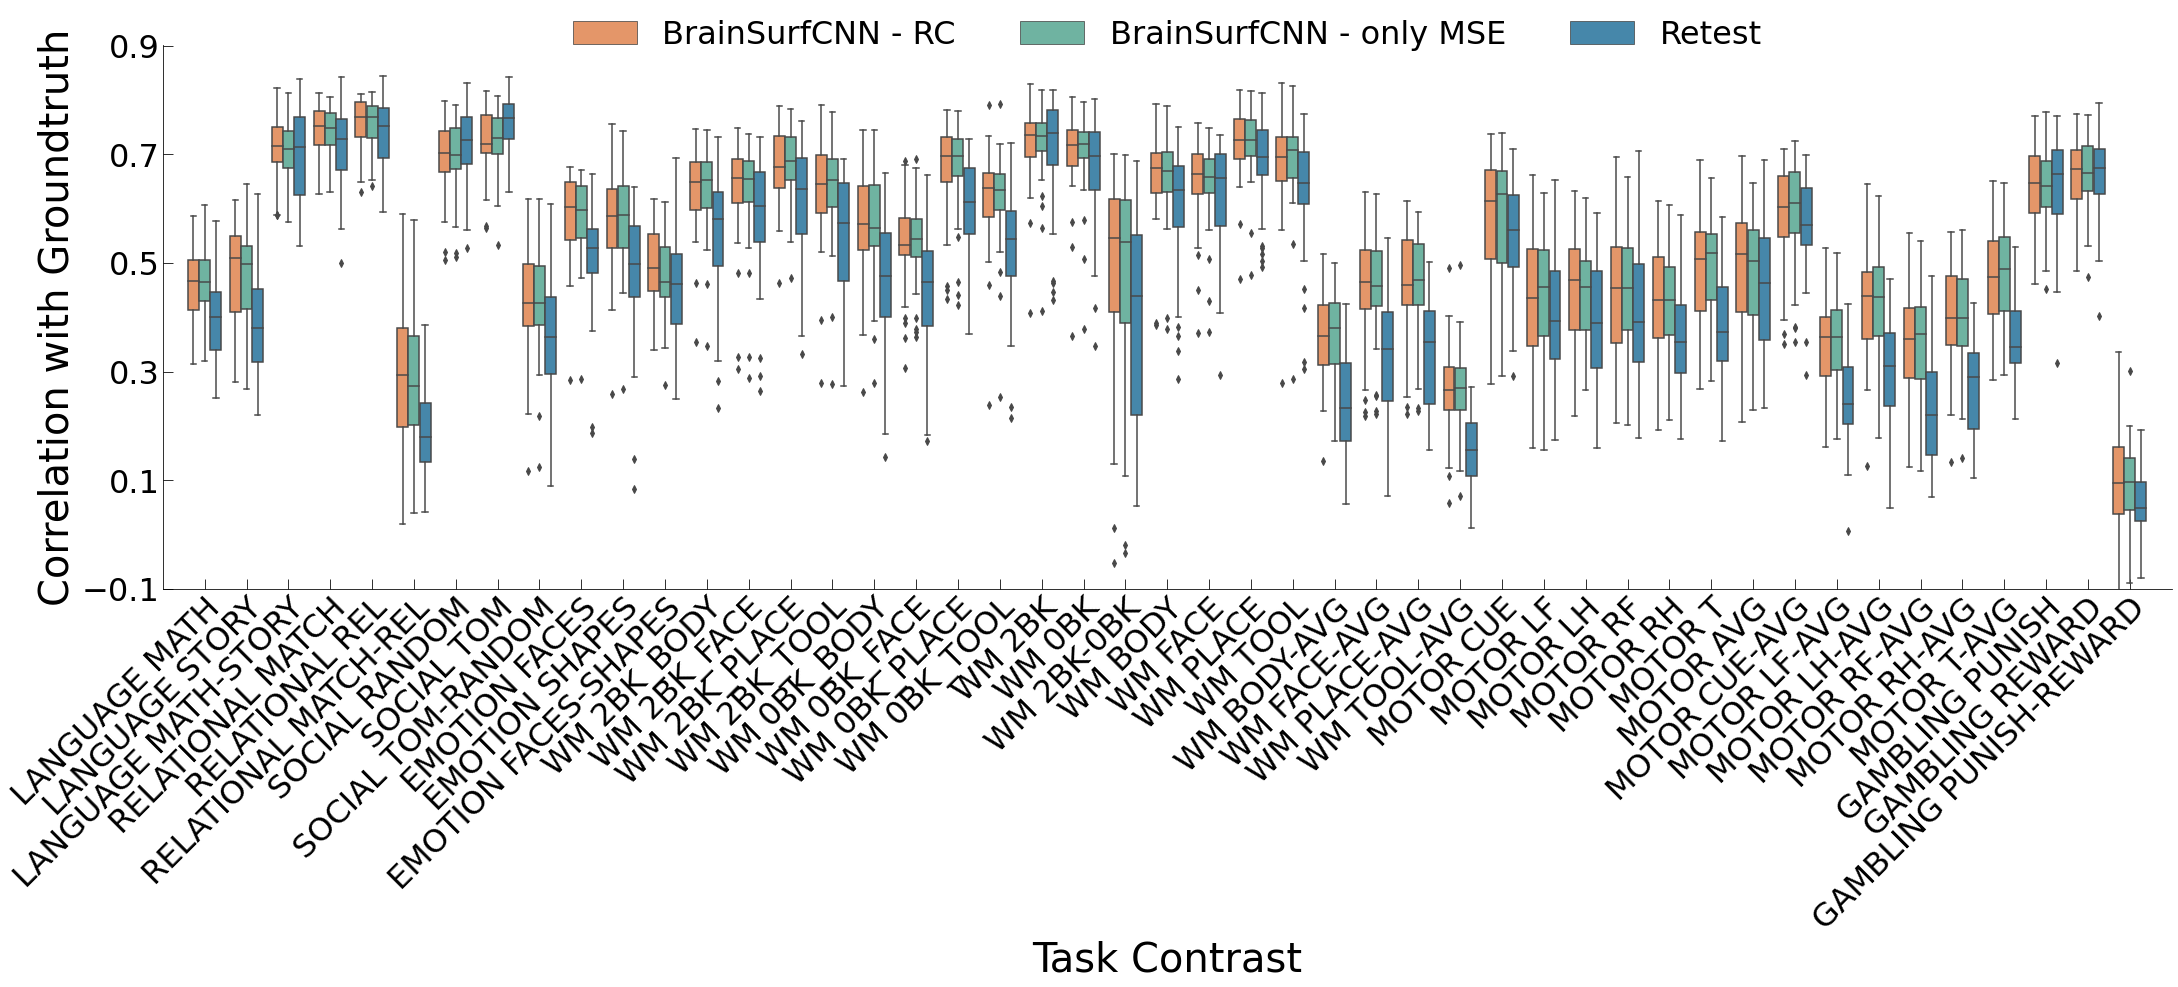

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(36, 10))
sns.boxplot(x="Task Contrast",
            y="Correlation with Groundtruth", hue="Model",
            data=df, ax=ax, # palette="Set3",
            hue_order=["BrainSurfCNN - RC", "BrainSurfCNN - only MSE", "Retest"])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
L = ax.legend(frameon=False, ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=32)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.1, 0.901)
ax.set_yticks(np.arange(-0.1, 0.901, 0.2))
ax.set_xlim(-1, len(CONTRASTS))
ax.tick_params(direction="in", labelsize=32)
ax.xaxis.get_label().set_fontsize(40)
ax.yaxis.get_label().set_fontsize(40)
ax.tick_params(length = 10)
